# Plant Classification
> Group: YoHRa  
> Members: ZHENG Yannan, DAI Changjun, HUANG Yueqiao

![avatar](https://pbs.twimg.com/profile_images/960531652119285760/vtcdJZw5_400x400.jpg)

**What we used:**

In [ ]:
!nvidia-smi -L

In [ ]:
pip install --upgrade efficientnet-pytorch

In [ ]:
pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

In [ ]:
import os
import re
import csv

import torch
import torch.nn as nn
import torchmetrics
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline
from nvidia.dali.plugin.pytorch import DALIClassificationIterator, LastBatchPolicy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Global variables:**

In [ ]:
NUM_CLASSES = 153
BATCH_SIZE = 40
NUM_THREADS = 8
NUM_EPOCHS = 14
VAL_SIZE = .1
NET_NAME = 'efficientnet-b3'

TRAIN_DIR = '../input/polytech-nice-data-science-course-2021/polytech/train'
TEST_DIR = '../input/polytech-nice-data-science-course-2021/polytech/test'

# Network

As written in the global variables, the network we finally choose is `EfficientNet-b3`. But why is it?


At the beginning, we considered increasing the depth of the network to improve accuracy. Thus we chose `Residual Neural Network(ResNet)`. We quickly surpassed the teacher's score with `ResNet152`.

But there are so many things that can be optimized. Considering from the network, there are three aspects that can increase accuracy: network depth, network width, and resolution.


We considered increasing the width so we tried to use `WideResNet`. However, its iteration speed is too slow to converge to a good solution in a limited time(same as `ResNeXt`).  So is there a model that takes into account these three aspects and efficiency? Then we saw `EfficientNet`.
  
The author's thinking is very simple:
>1. Use NAS (Neural Architecture Search) to search for a better Backbone, which is **EfficientNet-B0**.
>2. Scale the width, depth, and image resolution of the B0 model at the same time to get B1-B7.

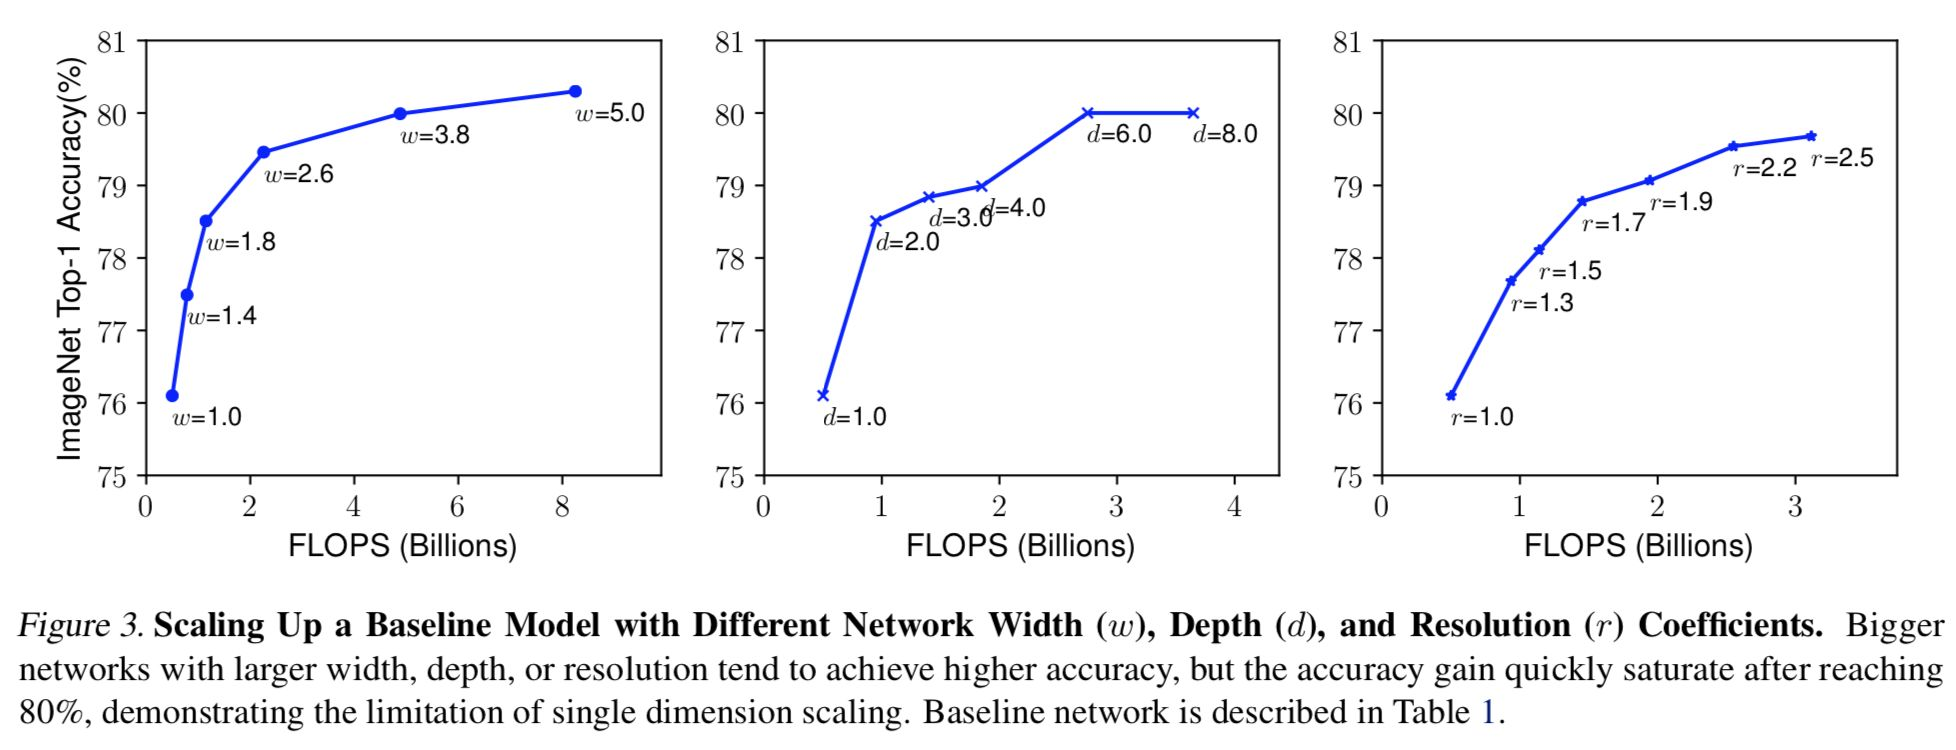

As stated in the paper, if only one aspect is improved, the accuracy will soon be saturated. This is why the performance of ResNet1000 and ResNet101 is almost the same.
These three aspects are interrelated. Only by improving them at the same time will you get better accuracy.


Due to performance and duration limitations, we chose the `B3` model after a few tests and abandoned the resolution scaling(224x224 instead of 300x300 so it can be trained 22 epochs). As we thought, the accuracy rate exceeded ResNet152. 

We can determine that the model has converged after 22 epochs but not after 15 epochs(tested in ResNet152). If we increase the resolution to 300x300 as specified in B3, will the model get better results without fully converging(because it can only be trained 14 epochs in 9 hours)?   
The answer is YES! 

# Training set and validation set

At the beginning, we have to select a part of the training set as the validation set. We decided to take only 10% as the validation set because of a huge number of images. 

Constructing a validation set that is approximately the same as the distribution of the test set is a way to obtain stable results, but this distribution is currently unknown. So what needs to be considered is to avoid the different distributions of the training set and the validation set. We found that the distribution is unbalanced. If it is splited randomly, the training set or validation set may not cover the entire sample space so that we cannot obtain stable results. During training, we will check the validation accuracy to select the best model. The dataset shift will prevent us from correctly evaluating the training effect so it must be avoided.

We use `train_test_split` to ensure that the number of images for each label in the two datasets is 9:1. 

In [ ]:
IMAGES = []
IMAGES_TARGETS = []

for dirname, _, filenames in os.walk(TRAIN_DIR):
    m = re.search(r'(?<=/)\d+', dirname)         #get labels with regular expression
    for filename in filenames:
        if filename.endswith('.jpg'):
            IMAGES.append((os.path.join(dirname, filename), int(m.group(0))-1))
            IMAGES_TARGETS.append(int(m.group(0))-1)
            
TRAIN_IMAGES, VAL_IMAGES = train_test_split(IMAGES,test_size=VAL_SIZE,
                                            shuffle=True,
                                            stratify=IMAGES_TARGETS)

train_dirs, train_labels = zip(*TRAIN_IMAGES)
val_dirs, val_labels = zip(*VAL_IMAGES)

# DALI from NVIDIA

The speed of training models with GPU is actually very fast. The reason for the slow speed is the loading and preprocessing of the data. In general, the method of loading and processing data is to construct the class of the dataset, reconstruct the `__getitem__` function, decode images by `Pillow` and use `transforms.Compose` `torch.DataLoader`. This is why the usage of cpu is always 100% but gpu is less than 50%.

In DALI, the JPEG decoding process uses the parallel utilization of GPU CUDA and software. The hybrid (CPU/GPU) method for Huffman decoding overcomes the pause in the serial process. Not only that, its multi-threaded loading is more efficient than DataLoader.

The following is the construction of the pipeline and iterator, including image loading and preprocessing. The preprocessing method is very common so we won't introduce it.

In [ ]:
class MyTrainPipe(Pipeline):
    def __init__(self, files, labels, batch_size, num_threads, device_id):
        super(MyTrainPipe, self).__init__(batch_size, num_threads, device_id, seed=12)
        self.input = ops.readers.File(files=files, labels=labels, random_shuffle=True)
        self.decode = ops.decoders.Image(device="mixed", output_type=types.RGB)
        self.res = ops.RandomResizedCrop(device="gpu", size=(300, 300), random_area=[0.08, 1.25])
        self.cmn = ops.CropMirrorNormalize(device="gpu",
                                            dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
                                            std=[0.229 * 255, 0.224 * 255, 0.225 * 255])
        self.coin = ops.random.CoinFlip(probability=0.5)

    def define_graph(self):
        self.jpegs, self.labels = self.input(name="Reader")
        images = self.decode(self.jpegs)
        images = self.res(images)
        output = self.cmn(images, mirror=self.coin())
        return output, self.labels


class MyValPipe(Pipeline):
    def __init__(self, files, labels, batch_size, num_threads, device_id):
        super(MyValPipe, self).__init__(batch_size, num_threads, device_id, seed=12)
        self.input = ops.readers.File(files=files, labels=labels)
        self.decode = ops.decoders.Image(device="mixed", output_type=types.RGB)
        self.res = ops.Resize(device="gpu", resize_shorter=324, interp_type=types.INTERP_TRIANGULAR)
        self.cmn = ops.CropMirrorNormalize(device="gpu",
                                            dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            crop=(300, 300),
                                            mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
                                            std=[0.229 * 255, 0.224 * 255, 0.225 * 255])

    def define_graph(self):
        self.jpegs, self.labels = self.input(name="Reader")
        images = self.decode(self.jpegs)
        images = self.res(images)
        output = self.cmn(images)
        return output, self.labels


def _make_net_iterator(type, files, labels, batch_size, num_threads, device_id=0):
    if type == 'train':
        ppl = MyTrainPipe(files=files, labels=labels, batch_size=batch_size, 
                                num_threads=num_threads, device_id=device_id)
        ppl.build()
        net_iter = DALIClassificationIterator(ppl, 
                                                     reader_name="Reader",
                                                     last_batch_policy=LastBatchPolicy.PARTIAL,
                                                     auto_reset=True)
        return net_iter
    
    elif type == 'val':
        ppl = MyValPipe(files=files, labels=labels, batch_size=batch_size, 
                            num_threads=num_threads, device_id=device_id)
        ppl.build()
        net_iter = DALIClassificationIterator(ppl, reader_name="Reader",
                                                   last_batch_policy=LastBatchPolicy.PARTIAL,
                                                   auto_reset=True)
        return net_iter

# Pytorch Lightning

This is a very easy-to-use framework but there are many issues. Not all issues can be solved because it's really a new framework.

So, just appreciate its concise structure.

In [ ]:
class MyNetwork(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.net = EfficientNet.from_pretrained(NET_NAME) 
        self.criterion = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy()
        self.lr = 1e-3
        
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        x = batch[0]["data"].squeeze().float()
        y = batch[0]["label"].squeeze().long()
        y_hat = self.net(x)
        acc = self.accuracy(y_hat, y)
        self.log('train_acc', acc, prog_bar=True)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss        
   
    def validation_step(self, batch, batch_idx):
        x = batch[0]["data"].squeeze().float()
        y = batch[0]["label"].squeeze().long()
        y_hat = self.net(x)
        acc = self.accuracy(y_hat, y)
        self.log('val_acc', acc, prog_bar=True, logger=True)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.SGD(self.net.parameters(), lr=self.lr, momentum=.9)


# Optimizer

With limited performance and duration, we chose `SGD with momentum` instead of Adam, which converges faster.

Of course, the accuracy of Adam is definitely not great for us. But from the perspective of the development process of the optimizer, Adam should perform better. 
So we tried to find the reason.
> https://openreview.net/forum?id=ryQu7f-RZ Adam may not converge in some cases.

> https://arxiv.org/abs/1705.08292 The adaptive learning rate algorithm may overfit the previous features.   
> Conclusion of this paper: Despite the fact that our experimental evidence demonstrates that adaptive methods are not advantageous for machine learning, the Adam algorithm remains incredibly popular. We are not sure exactly as to why...

> https://arxiv.org/abs/1712.07628 The later Adam's learning rate is too low, which affects effective convergence.

# O Captain! My Captain! Our wonderful trip begins!

As mentioned earlier, we will check the validation accuracy during training. 

After training, the best model will be exported.

In [ ]:
train_dl = _make_net_iterator(type='train', 
                                  files=train_dirs, 
                                  labels=train_labels,
                                  batch_size=BATCH_SIZE, 
                                  num_threads=NUM_THREADS)

val_dl = _make_net_iterator(type='val', 
                                files=val_dirs, 
                                labels=val_labels,
                                batch_size=BATCH_SIZE, 
                                num_threads=NUM_THREADS)

net = MyNetwork()

net_checkpoint = ModelCheckpoint(monitor = "val_acc",
                                 mode='max',
                                 verbose=True)

trainer = pl.Trainer(gpus=1,
                     max_epochs=NUM_EPOCHS,
                     accelerator='dp',
                     callbacks=[net_checkpoint],
                     checkpoint_callback=True)
trainer.tune(net, train_dl, val_dl)
trainer.fit(net, train_dl, val_dl)

trainer.save_checkpoint("best_net.ckpt")

Finally, classify the test set.

In [ ]:
test_transform = transforms.Compose([transforms.Resize(324),
                                     transforms.CenterCrop(300),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

net = MyNetwork.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
net.eval()
net.to(device)

headers = ['image_name', 'class']
results = []

for filename in tqdm(os.listdir(TEST_DIR)):
    if filename.endswith(".jpg"):
        img = Image.open(TEST_DIR+ '/' + filename).convert("RGB")
        data = test_transform(img)
        data = data.to(device)
        data = data.float()
        data = data.unsqueeze(0)
        pred = net(data)
        output = pred.max(1)[1]
        results.append({'image_name':filename, 'class':output.item()+1})

In [ ]:
with open('submission.csv','w',newline='') as f:
    f_csv = csv.DictWriter(f, headers)
    f_csv.writeheader()
    f_csv.writerows(results)

First training and submission accomplished!

# Tuning for SGD

Since we did not choose Adam, we can adjust the learning rate to train this model more times. At the same time, the re-splitting of the dataset also means that cross-validation is achieved. 

Thus we created a new notebook and upload the model we just exported. Initially, the learning rate is reduced to one-half each time. But it seems to drop so fast that the accuracy rate is not significantly improved. We slowed down its decay. In the end, we got the wonderful result that the tuning should have.

Public Score: 0.90647


Private Score: 0.90578

-------------------------------------------------------------------------------------------------------------------------

# Notes

1. This is not a serious report but a notebook that presents our thoughts on this challenge. We don't want to spend a lot of space to introduce this data set, code and algorithm though we've done a lot for them. Hope this notebook can clearly show all our thinking and efforts and will not waste readers' time.
2. Tensorboard is unsupported now in kaggle. The log of Pytorch Lightning cannot be visualized. What a pity.
3. We wanted to calculate the average of `val_acc` at the end of each epoch but -> RuntimeError: stack expects a non-empty TensorList -> Insurmountable:(
4. If we want to monitor the average of `val_acc`, it will be monitored before it is worked out -> Early stopping conditioned on metric `avg_val_acc` which is not available. Available metrics are: loss, val_acc <class 'RuntimeWarning'> -> Insurmountable:(
5. We once wanted to use Adam to quickly converge first and then use SGD to carefully adjust the learn rate according to what is described in the paper, but the actual effect is not great. Tuning is just the icing on the cake, Adam’s effect is indeed not satisfactory for us.
6. If we use `ImageFolder`, almost all the memory will be used up. Our idea of splitting and preprocessing the data set will not be realized. Thanks for `DALI` and `train_test_split`. Hope one day DALI will support Windows:(
7. Many people say we don’t need to care too much about the saddle. Maybe it's true because neural network embodies empiricism. This is one of the reasons why they still use SGD. And indeed SGD works well in this Kaggle Challenge.
8. Thanks for the notebooks in 2020's DS Kaggle Challenge. They gave us too much help.